### Project Title : - Using Lung ultrasound images for building a reliable Point-of-care Covid-19 testing system

####Multi Classifier : For classifying lung ultrasound images into one of the possible categories - Covid, Normal and Pneumonia

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
cd drive/MyDrive/

/content/drive/MyDrive


####Placing images into respective folder of their class from 'Non covid' to Pneumonia, Other and Normal

In [ ]:
import shutil
import os
path = "/content/drive/MyDrive/data/image/original/non_covid"

for file in os.listdir(path):
    if 'normal' in file:
        s = os.path.join(path,file)
        d = "/content/drive/MyDrive/data/image/original/normal"
        new_path = shutil.move(s,d)
    elif 'pneumonia' in file:
        s = os.path.join(path,file)
        d = "/content/drive/MyDrive/data/image/original/pneumonia"
        new_path = shutil.move(s,d)
    elif 'other' in file:
       s = os.path.join(path,file)
       d = "/content/drive/MyDrive/data/image/original/other"
       new_path = shutil.move(s,d)

####Checking number of images in each class

In [ ]:
import os

files = os.listdir("/content/drive/MyDrive/data/image/original/covid")
file_count = len(files)
print("Class Covid : ",file_count)

files = os.listdir("/content/drive/MyDrive/data/image/original/normal")
file_count = len(files)
print("Class Normal : ",file_count)

files = os.listdir("/content/drive/MyDrive/data/image/original/pneumonia")
file_count = len(files)
print("Class Pneumonia : ",file_count)

files = os.listdir("/content/drive/MyDrive/data/image/original/other")
file_count = len(files)
print("Class Other : ",file_count)



Class Covid :  3995
Class Normal :  2201
Class Pneumonia :  4269
Class Other :  7931


####Splitting dataset into Training, Testing and Validation

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##### Training dataset will be used for training the model, validation data will be used for adjusting the hyperparameters. The test dataset will be the unseen set of images, that'd be used for testing model's performance on the unseen dataset. 70% of the entire dataset is used as training, 10% as validation and the rest as testing.

In [ ]:
import splitfolders

#Splitting the entire dataset into training, testing and validation folders

splitfolders.ratio('/content/drive/MyDrive/data/image/original',output ='splitted_data', ratio = (.7,0.1,0.2))

Copying files: 10465 files [02:29, 70.09 files/s]


####Dataset Verification

##### The following piece of code checks the number of images in each class for all the three types of dataset.

In [ ]:
import os
print("Training dataset")
files = os.listdir("/content/drive/MyDrive/splitted_data/train/covid")
file_count = len(files)
print("Class Covid : ",file_count)

files = os.listdir("/content/drive/MyDrive/splitted_data/train/normal")
file_count = len(files)
print("Class Normal : ",file_count)

files = os.listdir("/content/drive/MyDrive/splitted_data/train/pneumonia")
file_count = len(files)
print("Class Pneumonia : ",file_count)

print("---------------------")
print("Testing dataset")
files = os.listdir("/content/drive/MyDrive/splitted_data/test/covid")
file_count = len(files)
print("Class Covid : ",file_count)

files = os.listdir("/content/drive/MyDrive/splitted_data/test/normal")
file_count = len(files)
print("Class Normal : ",file_count)

files = os.listdir("/content/drive/MyDrive/splitted_data/test/pneumonia")
file_count = len(files)
print("Class Pneumonia : ",file_count)

print("---------------------")
print("Validation dataset")
files = os.listdir("/content/drive/MyDrive/splitted_data/val/covid")
file_count = len(files)
print("Class Covid : ",file_count)

files = os.listdir("/content/drive/MyDrive/splitted_data/val/normal")
file_count = len(files)
print("Class Normal : ",file_count)

files = os.listdir("/content/drive/MyDrive/splitted_data/val/pneumonia")
file_count = len(files)
print("Class Pneumonia : ",file_count)

Training dataset
Class Covid :  2796
Class Normal :  1540
Class Pneumonia :  2988
---------------------
Testing dataset
Class Covid :  800
Class Normal :  441
Class Pneumonia :  855
---------------------
Validation dataset
Class Covid :  399
Class Normal :  220
Class Pneumonia :  426


####Dataset Loading and Pre-processing

##### It is important to pre-process the images before they are fed into the model. The image pre-processing has been done using Image Data Generator, as the dataset is huge and it'd be feasible to input data in batches. the batch size chosen is 512. The images are rescaled, so that the pixel values lie between 0-1 for all the images. The images have been resized to 197 X 198 pixels.

In [ ]:
#Importing the necessary libraries

import pathlib
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Creating path for dataset folders
p = Path().cwd()
q = p/'splitted_data'

#Images would be fed into the model as a batch of this size
batch_size = 512

#Rescaling the pixel values
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)


#Creating data generators for all the three datasets

train_generator = train_datagen.flow_from_directory(q/'train',target_size=(197, 198), batch_size= batch_size,class_mode ='categorical')

test_generator = test_datagen.flow_from_directory(q/'test',target_size= (197, 198), batch_size= batch_size,class_mode ='categorical')

val_generator = val_datagen.flow_from_directory(q/'val',target_size=(197, 198), batch_size= batch_size,class_mode ='categorical')')

# confirm the iterator works

batchX, batchy = train_generator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))


Found 7324 images belonging to 3 classes.
Found 2096 images belonging to 3 classes.
Found 1045 images belonging to 3 classes.
Batch shape=(512, 197, 198, 3), min=0.000, max=1.000


####Creating and Training Multi-classifier - VGG16

In [ ]:
pretrained= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(197,198,3), weights='imagenet')

pretrained.trainable=False


58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                      tf.keras.layers.RandomRotation(0.1),
                                      tf.keras.layers.RandomZoom(0.2)])

inputs = tf.keras.Input(shape=(197,198,3))
x = data_augmentation(inputs)
x = pretrained(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64)(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

multi_vgg16 = tf.keras.Model(inputs, outputs)

multi_vgg16.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 197, 198, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 197, 198, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 18432)             0         
                                                                 
 dense_14 (Dense)            (None, 64)                1179712   
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 3)                 195 

In [ ]:
multi_vgg16.compile(loss="categorical_crossentropy",optimizer="rmsprop", metrics=["accuracy"])

In [ ]:
multi_vgg16.fit( train_generator,steps_per_epoch = len(train_generator),epochs= 3 , validation_data= val_generator,
             validation_steps = len(val_generator))

Epoch 1/3
15/15 [==============================] - 85s 6s/step - loss: 9.8471 - accuracy: 0.4558 - val_loss: 2.5683 - val_accuracy: 0.6947
Epoch 2/3
15/15 [==============================] - 80s 5s/step - loss: 1.6024 - accuracy: 0.7388 - val_loss: 1.6130 - val_accuracy: 0.7598
Epoch 3/3
15/15 [==============================] - 79s 5s/step - loss: 2.0921 - accuracy: 0.7388 - val_loss: 2.4545 - val_accuracy: 0.7158


####Testing the multi-classifier on testing data

In [ ]:
final_loss, final_acc = multi_vgg16.evaluate(test_generator)
print("Test accuracy  : ",final_acc)

5/5 [==============================] - 453s 112s/step - loss: 2.5546 - accuracy: 0.7123
Test accuracy  :  0.7123091816902161


####Removing duplicate images from the dataset

##### This code removed duplicate images from each class : Covid, Normal, Pneumonia, Other

In [ ]:
!pip install scipy==1.2



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.6 MB 1.5 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.3.8 requires scipy>=1.2.1, but you have scipy 1.2.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import hashlib
from scipy.misc import imread, imresize, imshow
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import time
import numpy as np
import os

#####Class : Covid

In [ ]:

#Initialize empty list named as duplicates.
#Initialize empty dictionary names as hash_keys.

duplicates=[]
hash_keys=dict()
path ='/content/drive/MyDrive/covid'

# Open every files and read it and create hash value of each file in folder.
#We are using “md5" algorithm for generating Hash value . “hexdigest()” function is used for creating hash values of each file.
# If the file_hash is not in our hash_keys then give the index to file_hash. Else append the duplicate values into list named as duplicates.

for index, filename in enumerate(os.listdir(path)):
    x = os.path.join(path,filename)
    if os.path.isfile(x):
        with open(x, 'rb') as f:
            filehash = hashlib.md5(f.read()).hexdigest()
        if filehash not in hash_keys:
            hash_keys[filehash]=index
        else:
            duplicates.append((index,hash_keys[filehash]))

In [ ]:
duplicates

[(2459, 2458),
 (2460, 2458),
 (2461, 2458),
 (2462, 2458),
 (2463, 2458),
 (2464, 2458)]

In [ ]:
#Removing the images from the respective indices identified as duplicate
for index in duplicates:
  for i in index:
    x = files_list[i]
    path = '/content/drive/MyDrive/normal'
    y = os.path.join(path,x)
    os.remove(y)

#####Class : Normal

In [ ]:
duplicates=[]
hash_keys=dict()
path ='/content/drive/MyDrive/normal'

for index, filename in enumerate(os.listdir(path)):
    x = os.path.join(path,filename)
    if os.path.isfile(x):
        with open(x, 'rb') as f:
            filehash = hashlib.md5(f.read()).hexdigest()
        if filehash not in hash_keys:
            hash_keys[filehash]=index
        else:
            duplicates.append((index,hash_keys[filehash]))

In [ ]:
duplicates

[(176, 175),
 (180, 179),
 (184, 183),
 (188, 187),
 (192, 191),
 (196, 195),
 (200, 199),
 (204, 203),
 (208, 207),
 (212, 211),
 (216, 215),
 (220, 219),
 (224, 223),
 (228, 227),
 (232, 231),
 (236, 235),
 (240, 239),
 (244, 243),
 (248, 247),
 (252, 251),
 (256, 255),
 (260, 259),
 (264, 263),
 (268, 267),
 (272, 271),
 (276, 275),
 (280, 279),
 (284, 283),
 (288, 287),
 (292, 291),
 (296, 295),
 (300, 299),
 (304, 303),
 (308, 307),
 (312, 311),
 (316, 315),
 (320, 319),
 (324, 323),
 (328, 327),
 (332, 331),
 (336, 335),
 (340, 339),
 (344, 343),
 (348, 347),
 (352, 351),
 (356, 355),
 (360, 359),
 (364, 363),
 (368, 367)]

In [ ]:
for index in duplicates:
  for i in index:
    x = files_list[i]
    path = '/content/drive/MyDrive/normal'
    y = os.path.join(path,x)
    os.remove(y)

In [ ]:
path = '/content/drive/MyDrive/normal'
files_list = os.listdir(path)
print (len(files_list))

2103


#####Class : Pneumonia

In [ ]:
duplicates=[]
hash_keys=dict()
path ='/content/drive/MyDrive/xx/pneumonia'

for index, filename in enumerate(os.listdir(path)):
    x = os.path.join(path,filename)
    if os.path.isfile(x):
        with open(x, 'rb') as f:
            filehash = hashlib.md5(f.read()).hexdigest()
        if filehash not in hash_keys:
            hash_keys[filehash]=index
        else:
            duplicates.append((index,hash_keys[filehash]))

In [ ]:
duplicates

[(2864, 2863), (2867, 2863)]

In [ ]:
for index in duplicates:
  for i in index:
      x = files_list[i]
      path = '/content/drive/MyDrive/xx/pneumonia'
      y = os.path.join(path,x)
      os.remove(y)

FileNotFoundError: ignored

In [ ]:
path = '/content/drive/MyDrive/xx/pneumonia'
files_list = os.listdir(path)
print (len(files_list))

4226


####Creating and training a Mult-classifier after removing the duplicate images

####Splitting the dataset

##### Now that the duplicate images have been removed, we'd have to split up the dataset again.

In [ ]:
import splitfolders

#Splitting the entire dataset into training, testing and validation folders

splitfolders.ratio('/content/drive/MyDrive/My_Dataset',output ='splitted', ratio = (.7,0.1,0.2))

Copying files: 10312 files [01:34, 108.61 files/s]


####Dataset Verification

In [ ]:
import os
print("Training dataset")
files = os.listdir("/content/drive/MyDrive/splitted/train/covid")
file_count = len(files)
print("Class Covid : ",file_count)

files = os.listdir("/content/drive/MyDrive/splitted/train/normal")
file_count = len(files)
print("Class Normal : ",file_count)

files = os.listdir("/content/drive/MyDrive/splitted/train/pneumonia")
file_count = len(files)
print("Class Pneumonia : ",file_count)

print("---------------------")
print("Testing dataset")
files = os.listdir("/content/drive/MyDrive/splitted/test/covid")
file_count = len(files)
print("Class Covid : ",file_count)

files = os.listdir("/content/drive/MyDrive/splitted/test/normal")
file_count = len(files)
print("Class Normal : ",file_count)

files = os.listdir("/content/drive/MyDrive/splitted/test/pneumonia")
file_count = len(files)
print("Class Pneumonia : ",file_count)

print("---------------------")
print("Validation dataset")
files = os.listdir("/content/drive/MyDrive/splitted/val/covid")
file_count = len(files)
print("Class Covid : ",file_count)

files = os.listdir("/content/drive/MyDrive/splitted/val/normal")
file_count = len(files)
print("Class Normal : ",file_count)

files = os.listdir("/content/drive/MyDrive/splitted/val/pneumonia")
file_count = len(files)
print("Class Pneumonia : ",file_count)

Training dataset
Class Covid :  2792
Class Normal :  1467
Class Pneumonia :  2958
---------------------
Testing dataset
Class Covid :  799
Class Normal :  421
Class Pneumonia :  846
---------------------
Validation dataset
Class Covid :  398
Class Normal :  209
Class Pneumonia :  422


#### Dataset Loading and Pre-processing

In [ ]:
#Importing the necessary libraries

import pathlib
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Creating path for dataset folders
p = Path().cwd()
q = p/'splitted'

#Images would be fed into the model as a batch of this size
batch_size = 128

#Rescaling the pixel values
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)


#Creating data generators for all the three datasets

train_generator = train_datagen.flow_from_directory(q/'train',target_size=(197, 198), batch_size= batch_size,class_mode ='categorical')

test_generator = test_datagen.flow_from_directory(q/'test',target_size= (197, 198), batch_size= batch_size,class_mode ='categorical')

val_generator = val_datagen.flow_from_directory(q/'val',target_size=(197, 198), batch_size= batch_size,class_mode ='categorical')

# confirm the iterator works

batchX, batchy = train_generator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))


Found 7217 images belonging to 3 classes.
Found 2066 images belonging to 3 classes.
Found 1029 images belonging to 3 classes.
Batch shape=(128, 197, 198, 3), min=0.000, max=1.000


####Multi-classifier - VGG16

In [ ]:
pretrained= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(197,198,3), weights='imagenet')


In [ ]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                      tf.keras.layers.RandomRotation(0.1),
                                      tf.keras.layers.RandomZoom(0.2)])

inputs = tf.keras.Input(shape=(197,198,3))
x = data_augmentation(inputs)
x = pretrained(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

multi_vgg16 = tf.keras.Model(inputs, outputs)

multi_vgg16.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 197, 198, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 197, 198, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               9437696   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 1539

In [ ]:
multi_vgg16.compile(loss="categorical_crossentropy",optimizer="Adam", metrics=["accuracy"])


In [ ]:
network = multi_vgg16.fit( train_generator,steps_per_epoch = len(train_generator),epochs= 8 , validation_data= val_generator,
             validation_steps = len(val_generator))

Epoch 1/8
57/57 [==============================] - 590s 10s/step - loss: 4.4677 - accuracy: 0.4168 - val_loss: 1.0226 - val_accuracy: 0.5277
Epoch 2/8
57/57 [==============================] - 96s 2s/step - loss: 0.9729 - accuracy: 0.5355 - val_loss: 0.8174 - val_accuracy: 0.6229
Epoch 3/8
57/57 [==============================] - 95s 2s/step - loss: 0.8017 - accuracy: 0.6496 - val_loss: 0.7294 - val_accuracy: 0.6569
Epoch 4/8
57/57 [==============================] - 95s 2s/step - loss: 0.7187 - accuracy: 0.6936 - val_loss: 0.6817 - val_accuracy: 0.7104
Epoch 5/8
57/57 [==============================] - 93s 2s/step - loss: 0.6244 - accuracy: 0.7316 - val_loss: 0.4272 - val_accuracy: 0.8542
Epoch 6/8
57/57 [==============================] - 94s 2s/step - loss: 0.5666 - accuracy: 0.7626 - val_loss: 0.4811 - val_accuracy: 0.8367
Epoch 7/8
57/57 [==============================] - 94s 2s/step - loss: 0.5288 - accuracy: 0.7851 - val_loss: 0.3397 - val_accuracy: 0.8746
Epoch 8/8
57/57 [========

####Testing model performance on testing data

In [ ]:
final_loss, final_acc = multi_vgg16.evaluate(test_generator)
print("Test accuracy  : ",final_acc)

17/17 [==============================] - 352s 22s/step - loss: 0.3563 - accuracy: 0.8693
Test accuracy  :  0.8693127036094666


####Comparison of model's performance on training and validation data

##### It is imperative to compare model's accuracy and loss improvement on training and validation dataset to make sure it's not overfitting.

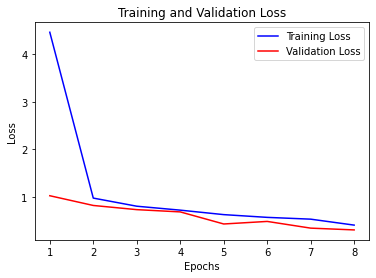

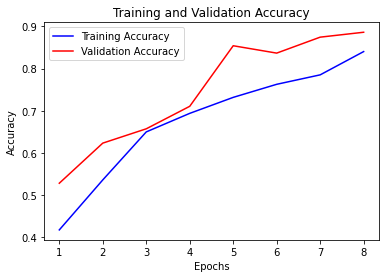

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Comparison of training and validation loss per epoch

history_dict = network.history # the dictionary that has the information on loss and accuracy per epoch

loss_values = history_dict['loss']   # training loss
val_loss_values = history_dict['val_loss'] # validation loss

epochs = range(1, len(loss_values)+1)  #creates list of integers to match the number of epochs of training

# code to plot the results
plt.plot(epochs, loss_values, 'b', label="Training Loss")
plt.plot(epochs, val_loss_values, 'r', label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.show()


#Comparison of training and validation accuracy per epoch

# As above, but this time we want to visualize the training and validation accuracy

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, 'b', label="Training Accuracy")
plt.plot(epochs, val_acc_values, 'r', label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.legend()
plt.show()

####Random Oversampling

##### Since, the Covid class does not have images comparable to other classes. We have tried oversampling this class to deal with class imbalance. 

In [ ]:
import splitfolders

#Splitting the entire dataset into training, testing and validation folders

#While splitting, we have specified to use 700 and 1000 images in each class in the validation and testing data respectively

#The rest of the images goes into the training dataset and images are oversampled in COVID class so that it can have as many images as in other classes.

splitfolders.fixed('/content/drive/MyDrive/My_Dataset',output ='val_test', seed = 123, fixed = (700,1000),oversample = True)

Copying files: 9962 files [05:24, 30.67 files/s] 
Oversampling: 3 classes [00:20,  7.00s/ classes]


In [ ]:
import os
print("Training dataset")
files = os.listdir("/content/drive/MyDrive/val_test/train/covid")
file_count = len(files)
print("Class Covid : ",file_count)

files = os.listdir("/content/drive/MyDrive/val_test/train/normal")
file_count = len(files)
print("Class Normal : ",file_count)

files = os.listdir("/content/drive/MyDrive/val_test/train/pneumonia")
file_count = len(files)
print("Class Pneumonia : ",file_count)

print("---------------------")
print("Testing dataset")
files = os.listdir("/content/drive/MyDrive/val_test/test/covid")
file_count = len(files)
print("Class Covid : ",file_count)

files = os.listdir("/content/drive/MyDrive/val_test/test/normal")
file_count = len(files)
print("Class Normal : ",file_count)

files = os.listdir("/content/drive/MyDrive/val_test/test/pneumonia")
file_count = len(files)
print("Class Pneumonia : ",file_count)

print("---------------------")
print("Validation dataset")
files = os.listdir("/content/drive/MyDrive/val_test/val/covid")
file_count = len(files)
print("Class Covid : ",file_count)

files = os.listdir("/content/drive/MyDrive/val_test/val/normal")
file_count = len(files)
print("Class Normal : ",file_count)

files = os.listdir("/content/drive/MyDrive/val_test/val/pneumonia")
file_count = len(files)
print("Class Pneumonia : ",file_count)

Training dataset
Class Covid :  2376
Class Normal :  2376
Class Pneumonia :  2376
---------------------
Testing dataset
Class Covid :  1000
Class Normal :  1000
Class Pneumonia :  1000
---------------------
Validation dataset
Class Covid :  700
Class Normal :  700
Class Pneumonia :  700


##### ResNet50 and VGG-19 have been used for the multi-classification task after oversampling.

####Multi-classifier ResNet50

In [ ]:
#Importing the necessary libraries

import pathlib
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Creating path for dataset folders
p = Path().cwd()
q = p/'val_test'

#Images would be fed into the model as a batch of this size
batch_size = 128

#Rescaling the pixel values
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)


#Creating data generators for all the three datasets

train_generator = train_datagen.flow_from_directory(q/'train',target_size=(197, 198), batch_size= batch_size,class_mode ='categorical')

test_generator = test_datagen.flow_from_directory(q/'test',target_size= (197, 198), batch_size= batch_size,class_mode ='categorical')

val_generator = val_datagen.flow_from_directory(q/'val',target_size=(197, 198), batch_size= batch_size,class_mode ='categorical')

# confirm the iterator works

batchX, batchy = train_generator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))


Found 7128 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 2100 images belonging to 3 classes.
Batch shape=(128, 197, 198, 3), min=0.000, max=1.000


In [ ]:
pretrained= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(197,198,3), weights='imagenet')


94781440/94765736 [==============================] - 2s 0us/step


In [ ]:


data_augmentation = tf.keras.Sequential([ tf.keras.layers.RandomFlip("horizontal"),
                                      tf.keras.layers.RandomZoom(0.2)])

inputs = tf.keras.Input(shape=(198,197,3))
x = data_augmentation(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256)(x)
outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

resnet = tf.keras.Model(inputs, outputs)

resnet.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 198, 197, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 198, 197, 3)       0         
                                                                 
 flatten_2 (Flatten)         (None, 117018)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               29956864  
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 29,957,635
Trainable params: 29,957,635
Non-trainable params: 0
_________________________________________________________________


In [ ]:
resnet.compile(loss="categorical_crossentropy",optimizer="rmsprop", metrics=["accuracy"])


In [ ]:
network_1 = resnet.fit( train_generator,steps_per_epoch = len(train_generator),epochs= 4 , validation_data= val_generator,
             validation_steps = len(val_generator))

Epoch 1/4
56/56 [==============================] - 82s 1s/step - loss: 47.8571 - accuracy: 0.5836 - val_loss: 11.8363 - val_accuracy: 0.7714
Epoch 2/4
56/56 [==============================] - 79s 1s/step - loss: 18.7917 - accuracy: 0.6786 - val_loss: 25.4301 - val_accuracy: 0.6086
Epoch 3/4
56/56 [==============================] - 80s 1s/step - loss: 12.3082 - accuracy: 0.7197 - val_loss: 3.1379 - val_accuracy: 0.8900
Epoch 4/4
56/56 [==============================] - 78s 1s/step - loss: 7.2302 - accuracy: 0.7419 - val_loss: 4.8297 - val_accuracy: 0.7514


In [ ]:
final_loss, final_acc = resnet.evaluate(test_generator)
print("Test accuracy  : ",final_acc)

24/24 [==============================] - 28s 1s/step - loss: 5.4469 - accuracy: 0.7373
Test accuracy  :  0.737333357334137


####Multi-classifier VGG-19

In [ ]:
pretrained= tf.keras.applications.VGG19(include_top=False,
                   input_shape=(197,198,3), weights='imagenet')


In [ ]:


data_augmentation = tf.keras.Sequential([ tf.keras.layers.RandomFlip("horizontal"),
                                      tf.keras.layers.RandomZoom(0.2)])

inputs = tf.keras.Input(shape=(198,197,3))
x = data_augmentation(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256)(x)
outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

VGG19 = tf.keras.Model(inputs, outputs)

VGG19.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 198, 197, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 198, 197, 3)       0         
                                                                 
 flatten_4 (Flatten)         (None, 117018)            0         
                                                                 
 dense_8 (Dense)             (None, 256)               29956864  
                                                                 
 dense_9 (Dense)             (None, 3)                 771       
                                                                 
Total params: 29,957,635
Trainable params: 29,957,635
Non-trainable params: 0
_________________________________________________________________


In [ ]:
VGG19.compile(loss="categorical_crossentropy",optimizer="rmsprop", metrics=["accuracy"])


In [ ]:
network_1 = VGG19.fit( train_generator,steps_per_epoch = len(train_generator),epochs= 5 , validation_data= val_generator,
             validation_steps = len(val_generator))

Epoch 1/5
56/56 [==============================] - 83s 1s/step - loss: 44.3020 - accuracy: 0.6068 - val_loss: 19.9427 - val_accuracy: 0.6662
Epoch 2/5
56/56 [==============================] - 81s 1s/step - loss: 18.5577 - accuracy: 0.6904 - val_loss: 14.7161 - val_accuracy: 0.6671
Epoch 3/5
56/56 [==============================] - 79s 1s/step - loss: 10.6646 - accuracy: 0.7291 - val_loss: 1.7710 - val_accuracy: 0.8976
Epoch 4/5
56/56 [==============================] - 80s 1s/step - loss: 5.9663 - accuracy: 0.7479 - val_loss: 7.8241 - val_accuracy: 0.5929
Epoch 5/5
56/56 [==============================] - 78s 1s/step - loss: 2.8923 - accuracy: 0.7764 - val_loss: 0.9016 - val_accuracy: 0.8248


In [ ]:
final_loss, final_acc = VGG19.evaluate(test_generator)
print("Test accuracy  : ",final_acc)

24/24 [==============================] - 28s 1s/step - loss: 1.1005 - accuracy: 0.8040
Test accuracy  :  0.8040000200271606


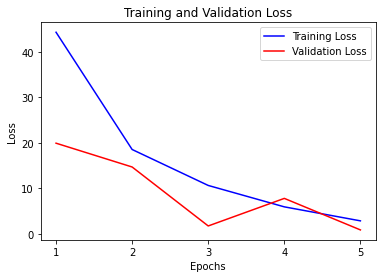

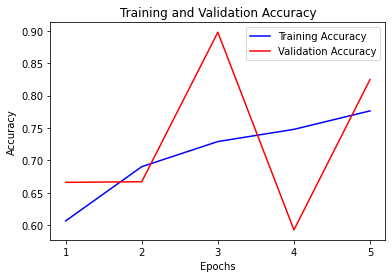

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Comparison of training and validation loss per epoch

history_dict = network_1.history # the dictionary that has the information on loss and accuracy per epoch

loss_values = history_dict['loss']   # training loss
val_loss_values = history_dict['val_loss'] # validation loss

epochs = range(1, len(loss_values)+1)  #creates list of integers to match the number of epochs of training

# code to plot the results
plt.plot(epochs, loss_values, 'b', label="Training Loss")
plt.plot(epochs, val_loss_values, 'r', label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.show()


#Comparison of training and validation accuracy per epoch

# As above, but this time we want to visualize the training and validation accuracy

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, 'b', label="Training Accuracy")
plt.plot(epochs, val_acc_values, 'r', label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.legend()
plt.show()